In [1]:
import wikipedia
import pandas as pd
from bs4 import BeautifulSoup
import requests

import cv2
import sklearn
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

import os
import json

from sklearn.cluster import KMeans

from colour_segmentation.base.segmentation_algorithm import SegmentationAlgorithm
from colour_segmentation.segmentator import Segmentator

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False

pd.set_option('display.max_colwidth', None)


# Look at data for Caravaggio's paintings - especially the colours

Uses this [Wikipedia list](https://en.wikipedia.org/wiki/List_of_paintings_by_Caravaggio). We'll parse the tables for each decade and get the data. We'll download all the original files of the paintings.

We'll also extract the colours from each painting to cluster them.

In [2]:
# Read the page and its HTML

page = wikipedia.page('List of paintings by Caravaggio')
html = page.html()

# Read the list of Caravaggio's paintings - there's only one real table
page_tables = pd.read_html(html)
df = page_tables[0].copy()   # make said table into a df

In [3]:
df[df.YearName.str.contains('Magdalene')]

,Painting,YearName,"City, Gallery",DimensionsTechnique,Notes
17,NaN,c. 1597:Penitent Magdalene,"Rome, Doria Pamphilj Gallery",122.5 × 98.5 cmOil on canvas,[9]
26,NaN,c. 1598:Martha and Mary Magdalene,"Detroit, Detroit Institute of Arts",97.8 × 132.7 cmOil on canvas,NaN
65,NaN,1605/1606:Magdalene grieving,"Rome, Private Collection",112 × 92 cmOil on canvas,NaN


In [6]:
# add col for just city

df['city'] = df['City, Gallery'].apply(lambda row: row.split(',')[0])

In [7]:
df.groupby('city').count()

,Painting,YearName,"City, Gallery",DimensionsTechnique,Notes
city,,,,,
Basel,0,1,1,1,1
Berlin,0,4,4,4,3
Cleveland,0,1,1,1,0
Cremona,0,1,1,1,0
Detroit,0,1,1,1,0
Dublin,0,1,1,1,0
Florence,0,9,9,9,4
Fort Worth,0,1,1,1,0
Genoa,0,1,1,1,0


In [96]:
# you'd see later that there's two missing imgs, the best thing to do is removing them
# manually from the df - use the webpage
df = df.drop([3, 65])

In [203]:
# we shall use BeautifulSoup directly to parse the table to get img links and attach to the df
soup = BeautifulSoup(html, 'lxml') # Parse the HTML as a string

table_all = soup.find_all('table')[0]

# and here we get the HREFs to the imgs for each
images = table_all.find_all('a', class_='mw-file-description')

image_links = ['https:' + image.find('img')['src'] for image in images]        

In [204]:
df['original_filename'] = image_links

In [205]:
'c. 1596 Lute Player'.split(':')[0].split('-')[0].split('-')[0]
#.replace('c. ', '')

'c. 1596 Lute Player'

In [206]:
df.head(2)

,Painting,YearName,"City, Gallery",DimensionsTechnique,Notes,original_filename,year,decade
0,NaN,c. 1592–1593:Boy Peeling Fruit,"Florence, Fondazione Roberto Longhi",75.5 × 64.4 cmOil on canvas,"One of several versions, one of which is Caravaggio's earliest known work[2]",https://upload.wikimedia.org/wikipedia/commons/thumb/0/03/CARAVAGGIO%2C_A_boy_peeling_fruit_%281593%29.jpg/170px-CARAVAGGIO%2C_A_boy_peeling_fruit_%281593%29.jpg,1592,1590
1,NaN,c. 1592-1593:Boy Peeling Fruit,"London, Hampton Court Palace – The Royal Collection",63 × 53 cmOil on canvas,"One of several versions, one of which is Caravaggio's earliest known work[3]",https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Caravaggio_-_A_boy_peeling_fruit_%28Royal_Collection%29.jpg/170px-Caravaggio_-_A_boy_peeling_fruit_%28Royal_Collection%29.jpg,1592,1590


In [207]:
# add a col for the year - for ranges we'll take the first
df['year'] = df['YearName'].apply(lambda row: row.split(':')[0].split('–')[0].split('-')[0].replace('c. ', ''))

In [209]:
# correct the wrong ones

df[['YearName', 'year']][20:30]

df['year'][12] = '1596'
df['year'][35] = '1600'

,YearName,year
21,"c. 1597:Jupiter, Neptune and Pluto",1597
22,c. 1597:Fortune Teller,1597
23,c. 1598:Saint Catherine of Alexandria,1598
24,c. 1598:Sacrifice of Isaac,1598
25,c. 1598:John the Baptist,1598
26,c. 1598:Martha and Mary Magdalene,1598
27,c. 1598:Portrait of Maffeo Barberini,1598
28,c. 1598:Judith Beheading Holofernes,1598
29,c. 1599:David and Goliath,1599
30,c. 1599:Narcissus,1599


/var/folders/38/x32ycmvj6zs1zqg8dn112ys40000gn/T/ipykernel_82178/1711545375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'][12] = '1596'
/var/folders/38/x32ycmvj6zs1zqg8dn112ys40000gn/T/ipykernel_82178/1711545375.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'][35] = '1600'


In [210]:
# add a col for the decade too 

df['year'] = df['year'].astype('int')

df['decade'] = df['year'].apply(lambda row: int(row/10)*10)

In [211]:
df['original_filename']

0                                         https://upload.wikimedia.org/wikipedia/commons/thumb/0/03/CARAVAGGIO%2C_A_boy_peeling_fruit_%281593%29.jpg/170px-CARAVAGGIO%2C_A_boy_peeling_fruit_%281593%29.jpg
1                   https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Caravaggio_-_A_boy_peeling_fruit_%28Royal_Collection%29.jpg/170px-Caravaggio_-_A_boy_peeling_fruit_%28Royal_Collection%29.jpg
2                                         https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/CARAVAGGIO%2C_A_boy_peeling_fruit_%281592%29.jpg/170px-CARAVAGGIO%2C_A_boy_peeling_fruit_%281592%29.jpg
4             https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Michelangelo_Merisi_da_Caravaggio%2C_Portrait_of_a_Prelate.jpg/170px-Michelangelo_Merisi_da_Caravaggio%2C_Portrait_of_a_Prelate.jpg
5                                                 https://upload.wikimedia.org/wikipedia/commons/thumb/8/85/Young_Sick_Bacchus-Caravaggio_%281593%29.jpg/170px-Young_Sick_Bacchus-Carava

# Now download all imgs

In [213]:
# # need to spoof it as a browser user agent otherwise wikimedia 
# r = requests.get('https://upload.wikimedia.org/wikipedia/commons/6/65/Pierre-Auguste_Renoir_-_Portrait_de_la_m%C3%A8re_de_Renoir.jpg', 
#                  headers={'User-agent': 'Mozilla/5.0'})


for index, row in df.iterrows():
    img_url = row['original_filename']
    print(img_url)
    r = requests.get(img_url, headers={'User-agent': 'Mozilla/5.0'})
    f = open('caravaggio/' + str(row['decade']) + '/' + row['YearName'] + '.jpeg', 'wb')
    f.write(r.content)
    f.close()


https://upload.wikimedia.org/wikipedia/commons/thumb/0/03/CARAVAGGIO%2C_A_boy_peeling_fruit_%281593%29.jpg/170px-CARAVAGGIO%2C_A_boy_peeling_fruit_%281593%29.jpg


10636

https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Caravaggio_-_A_boy_peeling_fruit_%28Royal_Collection%29.jpg/170px-Caravaggio_-_A_boy_peeling_fruit_%28Royal_Collection%29.jpg


12377

https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/CARAVAGGIO%2C_A_boy_peeling_fruit_%281592%29.jpg/170px-CARAVAGGIO%2C_A_boy_peeling_fruit_%281592%29.jpg


15622

https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Michelangelo_Merisi_da_Caravaggio%2C_Portrait_of_a_Prelate.jpg/170px-Michelangelo_Merisi_da_Caravaggio%2C_Portrait_of_a_Prelate.jpg


11059

https://upload.wikimedia.org/wikipedia/commons/thumb/8/85/Young_Sick_Bacchus-Caravaggio_%281593%29.jpg/170px-Young_Sick_Bacchus-Caravaggio_%281593%29.jpg


12694

https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Boy_with_a_Basket_of_Fruit_by_Caravaggio.jpg/170px-Boy_with_a_Basket_of_Fruit_by_Caravaggio.jpg


12020

https://upload.wikimedia.org/wikipedia/commons/thumb/2/2e/Caravaggio_%28Michelangelo_Merisi%29_-_Good_Luck_-_Google_Art_Project.jpg/170px-Caravaggio_%28Michelangelo_Merisi%29_-_Good_Luck_-_Google_Art_Project.jpg


7852

https://upload.wikimedia.org/wikipedia/commons/thumb/8/8e/Caravaggio_%28Michelangelo_Merisi%29_-_The_Cardsharps_-_Google_Art_Project.jpg/170px-Caravaggio_%28Michelangelo_Merisi%29_-_The_Cardsharps_-_Google_Art_Project.jpg


8549

https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Caravaggio_-_I_Musici.jpg/170px-Caravaggio_-_I_Musici.jpg


16063

https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Saint_Francis_of_Assisi_in_Ecstasy-Caravaggio_%28c.1595%29.jpg/170px-Saint_Francis_of_Assisi_in_Ecstasy-Caravaggio_%28c.1595%29.jpg


6265

https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/Caravaggio_-_Boy_Bitten_by_a_Lizard.jpg/170px-Caravaggio_-_Boy_Bitten_by_a_Lizard.jpg


10128

https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Caravaggioapollo.jpg/220px-Caravaggioapollo.jpg


8171

https://upload.wikimedia.org/wikipedia/commons/thumb/6/6a/Michelangelo_Caravaggio_020.jpg/170px-Michelangelo_Caravaggio_020.jpg


7619

https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/Lutniarz.jpg/170px-Lutniarz.jpg


7512

https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Canestra_di_frutta_%28Caravaggio%29.jpg/170px-Canestra_di_frutta_%28Caravaggio%29.jpg


10562

https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Caravaggio_-_Bacco_adolescente_-_Google_Art_Project.jpg/170px-Caravaggio_-_Bacco_adolescente_-_Google_Art_Project.jpg


11770

https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Michelangelo_Caravaggio_063.jpg/170px-Michelangelo_Caravaggio_063.jpg


7646

https://upload.wikimedia.org/wikipedia/commons/thumb/a/a6/Michelangelo_Caravaggio_025.jpg/170px-Michelangelo_Caravaggio_025.jpg


10010

https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Caravaggio_-_Medusa_-_Google_Art_Project.jpg/170px-Caravaggio_-_Medusa_-_Google_Art_Project.jpg


10848

https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Portrait_of_a_Courtesan_by_Caravaggio.jpg/170px-Portrait_of_a_Courtesan_by_Caravaggio.jpg


13198

https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/Jupiter%2C_Neptune_and_Pluto-Caravaggio_%28c.1597-1600%29.jpg/170px-Jupiter%2C_Neptune_and_Pluto-Caravaggio_%28c.1597-1600%29.jpg


27025

https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/La_Diseuse_de_bonne_aventure%2C_Caravaggio_%28Louvre_INV_55%29_02.jpg/170px-La_Diseuse_de_bonne_aventure%2C_Caravaggio_%28Louvre_INV_55%29_02.jpg


8761

https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/Caravaggio_-_Saint_Catherine_of_Alexandria_%28post-restoration_image%29.jpg/170px-Caravaggio_-_Saint_Catherine_of_Alexandria_%28post-restoration_image%29.jpg


13661

https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Michelangelo_Merisi_da_Caravaggio_-_The_Sacrifice_of_Isaac_-_WGA04202.jpg/170px-Michelangelo_Merisi_da_Caravaggio_-_The_Sacrifice_of_Isaac_-_WGA04202.jpg


6715

https://upload.wikimedia.org/wikipedia/commons/thumb/4/48/Caravaggio-Baptist-Toledo.jpg/170px-Caravaggio-Baptist-Toledo.jpg


24935

https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/Michelangelo_Merisi_da_Caravaggio_-_Martha_and_Mary_Magdalene_-_WGA04101.jpg/170px-Michelangelo_Merisi_da_Caravaggio_-_Martha_and_Mary_Magdalene_-_WGA04101.jpg


10260

https://upload.wikimedia.org/wikipedia/commons/thumb/b/bd/Caravaggio_Maffeo_Barberini.jpg/170px-Caravaggio_Maffeo_Barberini.jpg


10417

https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Caravaggio_Judith_Beheading_Holofernes.jpg/170px-Caravaggio_Judith_Beheading_Holofernes.jpg


9091

https://upload.wikimedia.org/wikipedia/commons/thumb/6/6b/David_and_Goliath_by_Caravaggio.jpg/170px-David_and_Goliath_by_Caravaggio.jpg


8461

https://upload.wikimedia.org/wikipedia/commons/thumb/2/29/Narcissus-Caravaggio_%281594-96%29_edited.jpg/170px-Narcissus-Caravaggio_%281594-96%29_edited.jpg


10252

https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Boy_Bitten_by_a_Lizard-Caravaggio_%28Longhi%29.jpg/170px-Boy_Bitten_by_a_Lizard-Caravaggio_%28Longhi%29.jpg


15352

https://upload.wikimedia.org/wikipedia/commons/thumb/8/89/BaptistBasle.jpg/170px-BaptistBasle.jpg


11638

https://upload.wikimedia.org/wikipedia/commons/thumb/1/10/Caravaggio_-_La_vocazione_di_San_Matteo.jpg/170px-Caravaggio_-_La_vocazione_di_San_Matteo.jpg


6590

https://upload.wikimedia.org/wikipedia/commons/thumb/5/57/The_Martyrdom_of_Saint_Matthew-Caravaggio_%28c._1599-1600%29.jpg/170px-The_Martyrdom_of_Saint_Matthew-Caravaggio_%28c._1599-1600%29.jpg


8913

https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/Caravaggio_005.jpg/170px-Caravaggio_005.jpg


8428

https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/The_Conversion_of_Saint_Paul-Caravaggio_%28c._1600-1%29.jpg/170px-The_Conversion_of_Saint_Paul-Caravaggio_%28c._1600-1%29.jpg


12156

https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Crucifixion_of_Saint_Peter-Caravaggio_%28c.1600%29.jpg/170px-Crucifixion_of_Saint_Peter-Caravaggio_%28c.1600%29.jpg


12043

https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/Caravaggio-The_Conversion_on_the_Way_to_Damascus.jpg/170px-Caravaggio-The_Conversion_on_the_Way_to_Damascus.jpg


16608

https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Flowersandfruit.jpg/170px-Flowersandfruit.jpg


9069

https://upload.wikimedia.org/wikipedia/commons/thumb/7/7f/The_Incredulity_of_Saint_Thomas.jpg/170px-The_Incredulity_of_Saint_Thomas.jpg


7753

https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/1602-3_Caravaggio%2CSupper_at_Emmaus_National_Gallery%2C_London.jpg/170px-1602-3_Caravaggio%2CSupper_at_Emmaus_National_Gallery%2C_London.jpg


8064

https://upload.wikimedia.org/wikipedia/commons/thumb/0/0c/Caravaggio_-_Cupid_as_Victor_-_Google_Art_Project.jpg/170px-Caravaggio_-_Cupid_as_Victor_-_Google_Art_Project.jpg


14444

https://upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Caravaggio_MatthewAndTheAngel_byMikeyAngels.jpg/170px-Caravaggio_MatthewAndTheAngel_byMikeyAngels.jpg


10275

https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/The_Inspiration_of_Saint_Matthew_by_Caravaggio.jpg/170px-The_Inspiration_of_Saint_Matthew_by_Caravaggio.jpg


16240

https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/Caravaggio_%28Michelangelo_Merisi%29_-_Saint_John_the_Baptist_-_Google_Art_Project.jpg/170px-Caravaggio_%28Michelangelo_Merisi%29_-_Saint_John_the_Baptist_-_Google_Art_Project.jpg


14894

https://upload.wikimedia.org/wikipedia/en/thumb/0/01/Caravaggio_Baptist_Galleria_Doria_Pamphili%2C_Rome.jpg/170px-Caravaggio_Baptist_Galleria_Doria_Pamphili%2C_Rome.jpg


14922

https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/Caravaggio_-_The_Incredulity_of_Saint_Thomas.jpg/170px-Caravaggio_-_The_Incredulity_of_Saint_Thomas.jpg


7530

https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Caravaggio_-_Taking_of_Christ_-_Dublin.jpg/170px-Caravaggio_-_Taking_of_Christ_-_Dublin.jpg


8122

https://upload.wikimedia.org/wikipedia/commons/thumb/6/60/Sacrifice_of_Isaac-Caravaggio_%28Uffizi%29.jpg/170px-Sacrifice_of_Isaac-Caravaggio_%28Uffizi%29.jpg


9128

https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/Caravaggio_-_Holy_Family_with_St._John_the_Baptist_%28Met%29.jpg/170px-Caravaggio_-_Holy_Family_with_St._John_the_Baptist_%28Met%29.jpg


11869

https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/Michelangelo_Caravaggio_052.jpg/170px-Michelangelo_Caravaggio_052.jpg


12561

https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/CaravaggioCrowning01.jpg/170px-CaravaggioCrowning01.jpg


8932

https://upload.wikimedia.org/wikipedia/commons/thumb/5/57/Madonna_di_Loreto-Caravaggio_%28c.1604-6%29.jpg/170px-Madonna_di_Loreto-Caravaggio_%28c.1604-6%29.jpg


12777

https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/Michelangelo_Merisi%2C_called_Caravaggio_-_Saint_John_the_Baptist_in_the_Wilderness_-_Google_Art_Project.jpg/170px-Michelangelo_Merisi%2C_called_Caravaggio_-_Saint_John_the_Baptist_in_the_Wilderness_-_Google_Art_Project.jpg


14039

https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/Michelangelo_Merisi_da_Caravaggio_-_St_John_the_Baptist_-_WGA04154.jpg/170px-Michelangelo_Merisi_da_Caravaggio_-_St_John_the_Baptist_-_WGA04154.jpg


5335

https://upload.wikimedia.org/wikipedia/commons/thumb/0/01/Michelangelo_Merisi_da_Caravaggio_%28Milan_1571-Port%27_Ercole_1610%29_-_The_Calling_of_Saints_Peter_and_Andrew_-_RCIN_402824_-_Hampton_Court_Palace.jpg/170px-Michelangelo_Merisi_da_Caravaggio_%28Milan_1571-Port%27_Ercole_1610%29_-_The_Calling_of_Saints_Peter_and_Andrew_-_RCIN_402824_-_Hampton_Court_Palace.jpg


7113

https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Michelangelo_Merisi_da_Caravaggio_-_Christ_in_the_Garden_-_Colourised_by_Mikey_Angels.jpg/170px-Michelangelo_Merisi_da_Caravaggio_-_Christ_in_the_Garden_-_Colourised_by_Mikey_Angels.jpg


7477

https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Caravaggio_%28Michelangelo_Merisi%29_-_Ecce_Homo_-_Google_Art_Project.jpg/170px-Caravaggio_%28Michelangelo_Merisi%29_-_Ecce_Homo_-_Google_Art_Project.jpg


11185

https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Michelangelo-merisi-da-caravaggio-1571-1610-S_1_1753.jpg/170px-Michelangelo-merisi-da-caravaggio-1571-1610-S_1_1753.jpg


10374

https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Saint_Jerome_Writing-Caravaggio_%281605-6%29.jpg/170px-Saint_Jerome_Writing-Caravaggio_%281605-6%29.jpg


6302

https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Pope_Paul_V.jpg/170px-Pope_Paul_V.jpg


17401

https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Caravaggio_-_Still_Life_with_Fruit_%28circa_1603%29.png/170px-Caravaggio_-_Still_Life_with_Fruit_%28circa_1603%29.png


30656

https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/CaravaggioSerpent.jpg/170px-CaravaggioSerpent.jpg


11436

https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Caravaggio_-_La_Morte_della_Vergine.jpg/170px-Caravaggio_-_La_Morte_della_Vergine.jpg


14788

https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Mary_magdalene_caravaggio.jpg/170px-Mary_magdalene_caravaggio.jpg


7742

https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/CaravaggioFrancisContemplation.jpg/170px-CaravaggioFrancisContemplation.jpg


7364

https://upload.wikimedia.org/wikipedia/commons/thumb/9/9c/CaravaggioEmmaus.jpg/170px-CaravaggioEmmaus.jpg


7346

https://upload.wikimedia.org/wikipedia/commons/thumb/6/6f/Caravaggio_-_Judith_and_Holophernes_Toulouse_-_High_Definition.jpg/170px-Caravaggio_-_Judith_and_Holophernes_Toulouse_-_High_Definition.jpg


10749

https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Caravaggio_-_Sette_opere_di_Misericordia.jpg/170px-Caravaggio_-_Sette_opere_di_Misericordia.jpg


15172

https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/Caravaggio_-_The_Crucifixion_of_Saint_Andrew_-_Post-Restoration.jpg/170px-Caravaggio_-_The_Crucifixion_of_Saint_Andrew_-_Post-Restoration.jpg


13823

https://upload.wikimedia.org/wikipedia/commons/thumb/7/70/Caravaggio_-_David_with_the_Head_of_Goliath_-_Vienna.jpg/170px-Caravaggio_-_David_with_the_Head_of_Goliath_-_Vienna.jpg


8180

https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Michelangelo_Merisi%2C_called_Caravaggio_-_Madonna_of_the_Rosary_-_Google_Art_Project.jpg/170px-Michelangelo_Merisi%2C_called_Caravaggio_-_Madonna_of_the_Rosary_-_Google_Art_Project.jpg


16178

https://upload.wikimedia.org/wikipedia/commons/thumb/5/52/Michelangelo_Merisi%2C_called_Caravaggio_-_The_Crowning_with_Thorns_-_Google_Art_Project.jpg/170px-Michelangelo_Merisi%2C_called_Caravaggio_-_The_Crowning_with_Thorns_-_Google_Art_Project.jpg


8924

https://upload.wikimedia.org/wikipedia/commons/thumb/0/0e/Caravaggio_-_La_Flagellazione_di_Cristo.jpg/170px-Caravaggio_-_La_Flagellazione_di_Cristo.jpg


9498

https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Caravaggio_flagellation.jpg/170px-Caravaggio_flagellation.jpg


6764

https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/CaravaggioSalomeLondon.jpg/170px-CaravaggioSalomeLondon.jpg


6655

https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/CaravaggioJeromeValletta.jpg/170px-CaravaggioJeromeValletta.jpg


5753

https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/Portrait_of_Alof_de_Wignacourt_and_his_Page-Caravaggio_%281607-1608%29.jpg/170px-Portrait_of_Alof_de_Wignacourt_and_his_Page-Caravaggio_%281607-1608%29.jpg


13694

https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/Portrait_of_Fra_Antonio_Martelli-Caravaggio_%281610%29.jpg/170px-Portrait_of_Fra_Antonio_Martelli-Caravaggio_%281610%29.jpg


10751

https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/The_Beheading_of_Saint_John-Caravaggio_%281608%29.jpg/170px-The_Beheading_of_Saint_John-Caravaggio_%281608%29.jpg


7012

https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/Caravaggio_sleeping_cupid.jpg/170px-Caravaggio_sleeping_cupid.jpg


3857

https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Michelangelo_Merisi_da_Caravaggio_-_St_John_the_Baptist_at_the_Well_-_WGA04201.jpg/170px-Michelangelo_Merisi_da_Caravaggio_-_St_John_the_Baptist_at_the_Well_-_WGA04201.jpg


13477

https://upload.wikimedia.org/wikipedia/commons/thumb/6/6c/Caravaggio_-_The_Annunciation.JPG/170px-Caravaggio_-_The_Annunciation.JPG


12034

https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Burial_of_Saint_Lucy-Caravaggio_%281608%29.jpg/170px-Burial_of_Saint_Lucy-Caravaggio_%281608%29.jpg


16030

https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/Michelangelo_Caravaggio_006.jpg/170px-Michelangelo_Caravaggio_006.jpg


12478

https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Caravaggio_-_Adorazione_dei_pastori.jpg/170px-Caravaggio_-_Adorazione_dei_pastori.jpg


11217

https://upload.wikimedia.org/wikipedia/commons/thumb/4/48/CaravaggioSalomeMadrid.jpg/170px-CaravaggioSalomeMadrid.jpg


7535

https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Toothpuller.jpg/170px-Toothpuller.jpg


5398

https://upload.wikimedia.org/wikipedia/commons/thumb/7/79/The_Denial_of_Saint_Peter-Caravaggio_%281610%29.jpg/170px-The_Denial_of_Saint_Peter-Caravaggio_%281610%29.jpg


7312

https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/CaravaggioFrancisPrayer.jpg/170px-CaravaggioFrancisPrayer.jpg


13475

https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/John_the_Baptist_%28Galleria_Borghese%29-Caravaggio_%281610%29.jpg/170px-John_the_Baptist_%28Galleria_Borghese%29-Caravaggio_%281610%29.jpg


9558

https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/David_holding_the_head_of_Goliath_by_Caravaggio_%28Rome%29.jpg/170px-David_holding_the_head_of_Goliath_by_Caravaggio_%28Rome%29.jpg


11091

https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Caravaggio-Baptist-reclining.jpg/170px-Caravaggio-Baptist-reclining.jpg


4842

https://upload.wikimedia.org/wikipedia/commons/thumb/6/61/CaravaggioUrsula.jpg/170px-CaravaggioUrsula.jpg


7649

In [216]:
!ls caravaggio/1610 | wc -l

       6


# Now investigate the colours!

Using a k-means with 5 clusters asked for for each picture

In [217]:
%%time

kmeans = KMeans(n_clusters=20)

# do one by one
dir_ = 'caravaggio/1590/'
d = {}

for filename in os.listdir(dir_):
    
    try:
    
        print(filename)

        img = io.imread(dir_ + filename)

        # resize (to half dimensions) so to reduce data, for speed
        img = cv2.resize(img, (0,0), fx=0.2, fy=0.2)
        img = np.reshape(img, (img.shape[0]*img.shape[1], 3))

        kmeans.fit(img)

        d[filename] = {'centroids': kmeans.cluster_centers_.tolist(),
                       'labels': kmeans.labels_.tolist()}
        
    # there can be some in wrong format    
    except:
        pass

c. 1598:Judith Beheading Holofernes.jpeg


/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c. 1596:Basket of Fruit.jpeg
c. 1597:Portrait of a Courtesan.jpeg
c. 1597:Medusa.jpeg


/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c. 1597:Jupiter, Neptune and Pluto.jpeg
c. 1598:John the Baptist.jpeg


/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c. 1595:Saint Francis of Assisi in Ecstasy.jpeg
c. 1599:David and Goliath.jpeg
c. 1594:Cardsharps.jpeg


/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c. 1593:Boy with a Basket of Fruit.jpeg
c. 1595:Musicians.jpeg
c. 1594:Fortune Teller.jpeg


/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c. 1592–1593:Boy Peeling Fruit.jpeg
c. 1598:Martha and Mary Magdalene.jpeg
c. 1597:Fortune Teller.jpeg


/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c. 1597:Penitent Magdalene.jpeg
c. 1593:Young Sick Bacchus.jpeg
c. 1596:Bacchus.jpeg


/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c. 1592–1599:Portrait of a Prelate[8].jpeg
c. 1597:Rest on the Flight into Egypt.jpeg
.ipynb_checkpoints
c. 1596:Lute Player.jpeg


/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c. 1592-1593:Boy Peeling Fruit.jpeg
c. 1598:Sacrifice of Isaac.jpeg
c. 1596 Lute Player.jpeg


/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c. 1596:Boy Bitten by a Lizard.jpeg
c. 1599:Narcissus.jpeg
c. 1598:Portrait of Maffeo Barberini.jpeg


/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c. 1598:Saint Catherine of Alexandria.jpeg
CPU times: user 4.28 s, sys: 310 ms, total: 4.59 s
Wall time: 2.67 s


/Users/martina/Desktop/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [218]:
len(d)

28

In [240]:
# dump to file
json.dump(d, open('renoir_1890_clusters_20.json', 'w'))

##  Read all files in, build single dict

For the RGB values, cast to int. For the labels, compute the occupation (in %) of each.

In [256]:
d_decades = {'1860': {}, '1870': {}, '1880': {}, '1890': {}, '1900': {}, '1910': {}}

for decade in d_decades:
    print(decade)
    d = json.load(open('renoir_{decade}_clusters.json'.format(decade=decade), 'r'))
    for title in d:
        d_decades[decade][title] = []
        for i in range(len(d[title]['centroids'])):
            d_decades[decade][title].append(
                {'colour': [int(item) for item in d[title]['centroids'][i]],
                 'occupation': round(d[title]['labels'].count(i) / len(d[title]['labels']), 2)
                })

1860
1870
1880
1890
1900
1910


In [257]:
d_decades['1880'].keys()

dict_keys(['Children on the Seashore, Guernsey(French: Enfants au Bord de la Mer, Guernesey).jpeg', 'Luncheon of the Boating Party(French: Le déjeuner des canotiers).jpeg', 'Blonde Bather (1881)(French: La baigneuse blonde).jpeg', 'Two Sisters (On the Terrace)(French: Les deux sœurs (Sur la terrasse)).jpeg', 'Portrait of Charles and George Durand-Ruel(French: Portrait de Charles et George Durand-Ruel).jpeg', 'Woman Arranging her Hair(fr:Femme se coiffant).jpeg', "Woman with Fan(French: Femme à l'éventail).jpeg", 'Dance in the City(French: Danse dans la Ville).jpeg', 'Pink and Blue(Alice and Elisabeth Cahen d’Anvers).jpeg', 'Fruits of the Midi(French: Fruits du midi).jpeg', 'Still Life, Roses of Wargemont(French: Nature morte, Roses de Wargemont).jpeg', 'Young Girls in Black(French: Jeunes filles en noir).jpeg', 'By the Seashore(French: Femme Assise au Bord de la Mer).jpeg', 'A Young Girl with Daisies(French: Une jeune fille avec des marguerites).jpeg', 'Children on the Beach of Guernse

In [645]:
d_decades['1880']['Portrait of Charles and George Durand-Ruel(French: Portrait de Charles et George Durand-Ruel).jpeg']

[{'colour': [155, 129, 107], 'occupation': 0.07},
 {'colour': [56, 46, 71], 'occupation': 0.1},
 {'colour': [111, 106, 117], 'occupation': 0.1},
 {'colour': [211, 196, 177], 'occupation': 0.08},
 {'colour': [80, 61, 51], 'occupation': 0.1},
 {'colour': [116, 94, 71], 'occupation': 0.07},
 {'colour': [148, 145, 143], 'occupation': 0.1},
 {'colour': [37, 24, 35], 'occupation': 0.1},
 {'colour': [82, 75, 96], 'occupation': 0.15},
 {'colour': [186, 166, 148], 'occupation': 0.12}]

In [210]:
title = 'Girl Playing Croquet(French/ Fille jouant au croquet).jpeg'

1860
1870
1880
1890
Girl Playing Croquet(French: Fille jouant au croquet).jpeg


<Figure size 1440x1440 with 0 Axes>

{'colour': [155, 108, 45], 'occupation': 0.1}
{'colour': [175, 114, 45], 'occupation': 0.09}
{'colour': [155, 28, 33], 'occupation': 0.08}
{'colour': [132, 25, 31], 'occupation': 0.08}
{'colour': [190, 131, 56], 'occupation': 0.07}
{'colour': [164, 122, 58], 'occupation': 0.06}
{'colour': [152, 89, 38], 'occupation': 0.06}
{'colour': [131, 92, 46], 'occupation': 0.06}
{'colour': [167, 47, 37], 'occupation': 0.06}
{'colour': [128, 68, 34], 'occupation': 0.05}
{'colour': [108, 19, 25], 'occupation': 0.04}
{'colour': [107, 77, 45], 'occupation': 0.04}
{'colour': [96, 56, 33], 'occupation': 0.04}
{'colour': [184, 66, 45], 'occupation': 0.04}
{'colour': [202, 149, 76], 'occupation': 0.03}
{'colour': [67, 30, 26], 'occupation': 0.03}
{'colour': [136, 109, 62], 'occupation': 0.03}
{'colour': [32, 12, 12], 'occupation': 0.02}
{'colour': [205, 88, 64], 'occupation': 0.01}
{'colour': [221, 181, 122], 'occupation': 0.0}
Yvonne et Christine Lerolle au piano(Yvonne and Christine Lerolle at the Pian

<Figure size 1440x1440 with 0 Axes>

{'colour': [16, 11, 18], 'occupation': 0.11}
{'colour': [45, 31, 29], 'occupation': 0.08}
{'colour': [177, 153, 75], 'occupation': 0.07}
{'colour': [196, 173, 91], 'occupation': 0.07}
{'colour': [75, 50, 40], 'occupation': 0.07}
{'colour': [154, 133, 66], 'occupation': 0.06}
{'colour': [132, 102, 57], 'occupation': 0.05}
{'colour': [216, 82, 55], 'occupation': 0.04}
{'colour': [185, 178, 148], 'occupation': 0.04}
{'colour': [158, 149, 112], 'occupation': 0.04}
{'colour': [221, 219, 195], 'occupation': 0.04}
{'colour': [121, 57, 43], 'occupation': 0.04}
{'colour': [217, 205, 161], 'occupation': 0.04}
{'colour': [169, 67, 49], 'occupation': 0.04}
{'colour': [230, 237, 233], 'occupation': 0.04}
{'colour': [128, 123, 89], 'occupation': 0.04}
{'colour': [98, 85, 57], 'occupation': 0.04}
{'colour': [222, 186, 112], 'occupation': 0.03}
{'colour': [185, 111, 64], 'occupation': 0.03}
{'colour': [216, 140, 83], 'occupation': 0.03}
In the Meadow(French: Dans le pré).jpeg


<Figure size 1440x1440 with 0 Axes>

{'colour': [76, 74, 85], 'occupation': 0.08}
{'colour': [91, 94, 101], 'occupation': 0.08}
{'colour': [203, 176, 136], 'occupation': 0.06}
{'colour': [103, 114, 123], 'occupation': 0.06}
{'colour': [129, 133, 132], 'occupation': 0.06}
{'colour': [155, 136, 97], 'occupation': 0.06}
{'colour': [121, 115, 97], 'occupation': 0.06}
{'colour': [108, 89, 67], 'occupation': 0.05}
{'colour': [170, 155, 130], 'occupation': 0.05}
{'colour': [58, 54, 67], 'occupation': 0.05}
{'colour': [177, 100, 84], 'occupation': 0.04}
{'colour': [139, 114, 69], 'occupation': 0.04}
{'colour': [51, 30, 37], 'occupation': 0.04}
{'colour': [94, 55, 47], 'occupation': 0.04}
{'colour': [147, 155, 160], 'occupation': 0.04}
{'colour': [187, 159, 99], 'occupation': 0.04}
{'colour': [215, 203, 175], 'occupation': 0.04}
{'colour': [195, 129, 114], 'occupation': 0.04}
{'colour': [180, 176, 170], 'occupation': 0.04}
{'colour': [149, 68, 58], 'occupation': 0.03}
Woman Playing a Guitar(French: Femme jouant de la guitare).jpeg

<Figure size 1440x1440 with 0 Axes>

{'colour': [20, 25, 18], 'occupation': 0.1}
{'colour': [36, 41, 15], 'occupation': 0.08}
{'colour': [125, 118, 95], 'occupation': 0.07}
{'colour': [134, 133, 120], 'occupation': 0.06}
{'colour': [133, 79, 25], 'occupation': 0.06}
{'colour': [154, 154, 144], 'occupation': 0.05}
{'colour': [140, 45, 8], 'occupation': 0.05}
{'colour': [94, 81, 44], 'occupation': 0.05}
{'colour': [66, 26, 12], 'occupation': 0.05}
{'colour': [175, 60, 8], 'occupation': 0.05}
{'colour': [102, 57, 17], 'occupation': 0.05}
{'colour': [132, 100, 56], 'occupation': 0.05}
{'colour': [170, 86, 42], 'occupation': 0.04}
{'colour': [103, 99, 75], 'occupation': 0.04}
{'colour': [44, 53, 39], 'occupation': 0.04}
{'colour': [104, 24, 6], 'occupation': 0.04}
{'colour': [66, 67, 15], 'occupation': 0.04}
{'colour': [167, 111, 77], 'occupation': 0.03}
{'colour': [167, 139, 111], 'occupation': 0.03}
{'colour': [171, 177, 173], 'occupation': 0.02}
Portrait of Victorine de Bellio (French: Portrait de Mademoiselle Victorine de 

<Figure size 1440x1440 with 0 Axes>

{'colour': [76, 43, 28], 'occupation': 0.08}
{'colour': [42, 20, 10], 'occupation': 0.08}
{'colour': [60, 31, 18], 'occupation': 0.08}
{'colour': [59, 55, 52], 'occupation': 0.07}
{'colour': [21, 12, 6], 'occupation': 0.07}
{'colour': [96, 91, 82], 'occupation': 0.06}
{'colour': [90, 61, 37], 'occupation': 0.06}
{'colour': [80, 75, 67], 'occupation': 0.06}
{'colour': [111, 70, 53], 'occupation': 0.05}
{'colour': [113, 107, 97], 'occupation': 0.05}
{'colour': [43, 38, 34], 'occupation': 0.05}
{'colour': [152, 141, 130], 'occupation': 0.05}
{'colour': [131, 86, 66], 'occupation': 0.04}
{'colour': [97, 46, 43], 'occupation': 0.04}
{'colour': [134, 126, 114], 'occupation': 0.04}
{'colour': [148, 106, 82], 'occupation': 0.03}
{'colour': [169, 132, 99], 'occupation': 0.02}
{'colour': [200, 170, 147], 'occupation': 0.02}
{'colour': [184, 153, 128], 'occupation': 0.02}
{'colour': [238, 213, 181], 'occupation': 0.0}
Gabrielle Renard and infant son, Jean(French: Gabrielle Renard et Jean enfant).

<Figure size 1440x1440 with 0 Axes>

{'colour': [198, 156, 107], 'occupation': 0.09}
{'colour': [172, 149, 112], 'occupation': 0.08}
{'colour': [115, 102, 61], 'occupation': 0.07}
{'colour': [134, 116, 77], 'occupation': 0.07}
{'colour': [183, 140, 91], 'occupation': 0.06}
{'colour': [212, 170, 122], 'occupation': 0.06}
{'colour': [155, 132, 95], 'occupation': 0.06}
{'colour': [214, 185, 147], 'occupation': 0.06}
{'colour': [187, 165, 134], 'occupation': 0.05}
{'colour': [80, 80, 73], 'occupation': 0.05}
{'colour': [228, 203, 164], 'occupation': 0.05}
{'colour': [99, 85, 49], 'occupation': 0.05}
{'colour': [98, 98, 91], 'occupation': 0.04}
{'colour': [139, 101, 52], 'occupation': 0.04}
{'colour': [164, 121, 70], 'occupation': 0.04}
{'colour': [69, 62, 50], 'occupation': 0.04}
{'colour': [244, 222, 185], 'occupation': 0.03}
{'colour': [123, 120, 111], 'occupation': 0.02}
{'colour': [44, 37, 27], 'occupation': 0.02}
{'colour': [253, 243, 219], 'occupation': 0.02}
Bathers Playing with a Crab(French: Baigneurs jouant avec un 

<Figure size 1440x1440 with 0 Axes>

{'colour': [129, 108, 81], 'occupation': 0.1}
{'colour': [142, 121, 95], 'occupation': 0.09}
{'colour': [107, 100, 78], 'occupation': 0.08}
{'colour': [158, 135, 109], 'occupation': 0.08}
{'colour': [93, 85, 62], 'occupation': 0.08}
{'colour': [132, 137, 134], 'occupation': 0.07}
{'colour': [150, 157, 154], 'occupation': 0.06}
{'colour': [120, 90, 62], 'occupation': 0.06}
{'colour': [174, 151, 127], 'occupation': 0.05}
{'colour': [112, 117, 110], 'occupation': 0.05}
{'colour': [72, 71, 51], 'occupation': 0.05}
{'colour': [114, 149, 159], 'occupation': 0.04}
{'colour': [91, 131, 144], 'occupation': 0.04}
{'colour': [98, 61, 35], 'occupation': 0.03}
{'colour': [52, 42, 30], 'occupation': 0.03}
{'colour': [73, 98, 101], 'occupation': 0.03}
{'colour': [186, 173, 155], 'occupation': 0.03}
{'colour': [27, 76, 92], 'occupation': 0.02}
{'colour': [209, 202, 187], 'occupation': 0.01}
{'colour': [151, 59, 35], 'occupation': 0.01}
Girls at the Piano(French: Jeunes filles au piano).jpeg


<Figure size 1440x1440 with 0 Axes>

{'colour': [143, 120, 82], 'occupation': 0.08}
{'colour': [132, 110, 75], 'occupation': 0.08}
{'colour': [152, 130, 91], 'occupation': 0.07}
{'colour': [121, 98, 69], 'occupation': 0.07}
{'colour': [107, 85, 62], 'occupation': 0.06}
{'colour': [130, 121, 95], 'occupation': 0.06}
{'colour': [116, 110, 84], 'occupation': 0.06}
{'colour': [144, 133, 109], 'occupation': 0.05}
{'colour': [163, 142, 101], 'occupation': 0.05}
{'colour': [91, 72, 53], 'occupation': 0.05}
{'colour': [102, 97, 76], 'occupation': 0.05}
{'colour': [159, 146, 121], 'occupation': 0.05}
{'colour': [85, 82, 66], 'occupation': 0.04}
{'colour': [172, 160, 136], 'occupation': 0.04}
{'colour': [185, 174, 148], 'occupation': 0.04}
{'colour': [74, 59, 47], 'occupation': 0.04}
{'colour': [196, 189, 168], 'occupation': 0.03}
{'colour': [177, 158, 116], 'occupation': 0.03}
{'colour': [54, 40, 36], 'occupation': 0.02}
{'colour': [212, 207, 190], 'occupation': 0.02}
1900
1910


<Figure size 1440x1440 with 0 Axes>

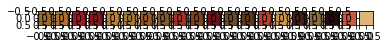

<Figure size 1440x1440 with 0 Axes>

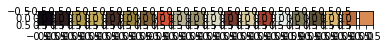

<Figure size 1440x1440 with 0 Axes>

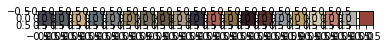

<Figure size 1440x1440 with 0 Axes>

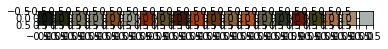

<Figure size 1440x1440 with 0 Axes>

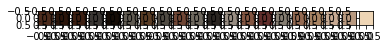

<Figure size 1440x1440 with 0 Axes>

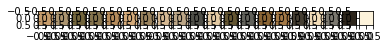

<Figure size 1440x1440 with 0 Axes>

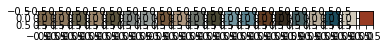

<Figure size 1440x1440 with 0 Axes>

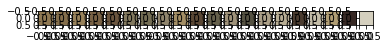

In [245]:
# spit a jpeg for each decade with the kmeans colours of each title
for decade in d_decades:
    print(decade)
    for title in d_decades[decade]:
        print(title)
        plt.figure(figsize=(20,20))

        fig, axs = plt.subplots(1, 20)

        l_ = d_decades[decade][title]    # list of dicts for the title
        # sort by occupation down
        l_ = sorted(l_, key=lambda d: d['occupation'],reverse=True)
        for i in range(20):
            print(l_[i])
            _ = axs[i].imshow(np.full((1,1,3), l_[i]['colour']));

        plt.savefig('colours_20_' + decade + '/' + title.split('.')[0] + '_colours.jpeg')

In [255]:
d_decades['1880']

{}

In [236]:
data

array([[11.6244039 ,  3.46713   , 16.83682015, 12.09934398, 15.17727766,
         0.51378802,  5.48534208, 16.31473254,  4.64972173,  3.27978638],
       [11.13847276, 16.93084413, 10.2415551 ,  2.23732427, 18.32590588,
        19.70538719,  4.75854738, 19.99413943,  2.16818373,  7.94997806],
       [ 2.35217326,  1.4025226 , 10.38568409,  5.17951055, 19.07901182,
        19.3233866 , 15.35105277, 16.64708453,  9.30843768, 12.43859931],
       [ 2.09187632,  0.92849605, 12.71162729, 13.12438397,  8.86263144,
         4.13323628,  8.7258948 , 19.94850572,  1.81651024,  7.88690222],
       [16.38567633,  4.61187408, 13.25967103,  0.44797796,  9.35938552,
         4.05065992, 15.1219138 ,  8.09832066,  6.11309954,  4.19947296],
       [12.40112782, 17.60086695,  9.09412138,  3.78351877, 15.62723381,
         4.61828838, 19.60987579,  0.51049105,  3.78644878, 12.09224788],
       [13.85071606, 16.29293354, 13.94802504,  5.45241954, 11.770041  ,
        14.1673583 ,  0.77303087, 10.15850093

In [251]:
# data = np.random.rand(10, 10) * 20

# # create discrete colormap
# cmap = colors.ListedColormap(['red', 'blue'])
# bounds = [0,10,20]
# norm = colors.BoundaryNorm(bounds, cmap.N)

# fig, ax = plt.subplots()
# ax.imshow(data, cmap=cmap, norm=norm);

# # draw gridlines
# ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
# ax.set_xticks(np.arange(-.5, 10, 1));
# ax.set_yticks(np.arange(-.5, 10, 1));

# plt.show()

## Other method: compare image to some palettes

### Renoir's palette

What was Renoir's standard palette is info I got from [here](https://www.jacksonsart.com/blog/2014/08/12/colours-used-sargent-renoir/) and [here](https://webartacademy.com/renoirs-palette) (taken from this one really). 

The k-means methos is too coarse, gives us colours that are too similar painting by painting. Instead, what about we measure how much each painting is using of his palette.

The RGB of these colours have been chosen with a quick google search.

#### Some interesting videos about these colours:
* [flake white](https://www.youtube.com/watch?v=vx6BI3Fqr6U)

This won't do - too subjective, there's no green, plus it's his, so it is derived from his own paintings, hence circular reasoning

### A standard palette?


### Saturated colours + 

### Renoir's palette colours

<Figure size 720x720 with 0 Axes>

[236, 236, 236]
[250, 218, 94]
[255, 87, 51]
[35, 31, 32]
[128, 96, 67]
[245, 197, 44]
[247, 74, 70]
[200, 8, 21]
[0, 71, 171]
[184, 78, 112]


<Figure size 720x720 with 0 Axes>

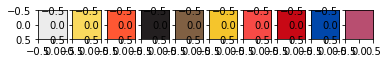

In [219]:
# renoir's palette
d_r_palette = {
    'flake_white':[236, 236, 236],
    'naples_yellow':[250 ,218, 94],
    'viridian':[255, 87, 51],
    'ivory_black':[35, 31, 32],
    'natural_earth':[128, 96, 67],
    'yellow_ochre':[245,197,44],
    'carmine':[247, 74, 70], # cannot find superfine carmine
    'venetian_red':[200, 8, 21],
    'cobalt_blue':[0, 71, 171],
    'lake_red':[184, 78, 112]
}

plt.figure(figsize=(10,10))

fig, axs = plt.subplots(1, 10)

l_ = list(d_r_palette.values())   # list of dicts for the title

for i in range(10):
    print(l_[i])
    _ = axs[i].imshow(np.full((1,1,3), l_[i]));

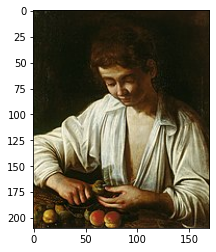

In [2]:
img = io.imread('caravaggio/1590/c. 1592-1593:Boy Peeling Fruit.jpeg')

plt.imshow(img)

In [3]:
# for row in img:
#     print(row)

## Trying image segmentation

with proper techniques, using this [lib](https://pypi.org/project/colour-segmentation/)

In [70]:
img = cv2.imread("caravaggio/1600/c. 1607:Flagellation of Christ.jpeg")   # the lib is designed to work with OpenCV, so reading BGR
#img = cv2.imread('/Users/martina/Downloads/nectarine.jpeg')
img = cv2.resize(img, (0,0), fx=0.2, fy=0.2)    # for speed

segmentator = Segmentator(image=img)

In [71]:
# result_liu = segmentator.segment(method=SegmentationAlgorithm.FUZZY_SET_LIU,
#                                  apply_colour_correction=False,
#                                  remove_achromatic_colours=True)

result_amante_fonseca_achr = segmentator.segment(method=SegmentationAlgorithm.FUZZY_SET_CHAMORRO,
                                                 remove_achromatic_colours=False)

In [72]:
result_amante_fonseca_achr.segmented_classes.max()
sum([result_amante_fonseca_achr.get_colour_proportion(i) for i in range(len(colours_cm))])
[result_amante_fonseca_achr.get_colour_proportion(i) for i in range(len(colours_cm))]
result_amante_fonseca_achr.get_colour_proportion(1)

11

0.9999999999999999

[0.1758169934640523,
 0.611764705882353,
 0.06470588235294118,
 0.00718954248366013,
 0.0,
 0.00718954248366013,
 0.00065359477124183,
 0.00718954248366013,
 0.011764705882352941,
 0.00718954248366013,
 0.00784313725490196,
 0.09869281045751634]

0.611764705882353

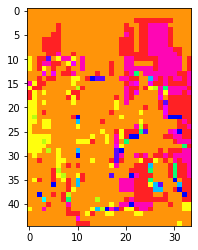

In [73]:
plt.imshow(cv2.cvtColor(result_amante_fonseca_achr.segmented_image, cv2.COLOR_BGR2RGB))

### Systematically and with all methods

Each method uses a different set of colours. The colours for each method are taken from the lib docs [here](https://mmunar97.gitbook.io/colour-segmentation/examples/examples-of-fuzzy-logic-based-methods)

We'll be useing each method with the flag that removes the achromatic colours (white, black, grey).

In [40]:
# Amante-Fonseca
colours_af = {
    0: [255, 33, 36],     # red
    1: [170, 121, 66],    # brown
    2: [255, 146, 0],      # orange
    3: [255, 251, 0],       # yellow
    4: [0, 255, 0],          # green
    5: [0, 253, 255],       # cyan
    6: [0, 0, 255],        # blue
    7: [147, 33, 146],     # purple
    8: [255, 64, 255]      # pink
}

# Chamorro - Martinez
colours_cm = {
    0: [255, 33, 36],     # red
    1: [255, 148, 9],      # orange
    2: [255, 255, 13],      # yellow
    3: [186, 255, 15],      # yellow-green
    4: [6, 155, 9],        # green
    5: [12, 255, 116],      # green-cyan
    6: [11, 254, 255],       # cyan
    7: [8, 192, 255],        # cyan-blue
    8: [0, 0, 255],         # blue
    9: [92, 8, 253],         # blue-magenta
    10: [238, 3, 249],       # magenta
    11: [254, 6, 180]        # magenta-red
}

# Liu-Wang
colours_lw = {
    0: [255, 33, 36],       # red
    1: [248, 149, 29],       #orange
    2: [239, 233, 17],       # yellow
    3: [105, 189, 69],        # green
    4: [111, 204, 221],       # cyan
    5: [59, 83, 164],          # blue
    6: [158, 80, 159]        # purple
}

# Shamir
colours_s = {
    0: [255, 33, 36],       # red
    1: [255, 140, 0],       # dark orange
    2: [255, 165, 0],        # light orange
    3: [255, 255, 0],        # yellow
    4: [144, 238, 144],      # light green
    5: [0, 100, 0],          # dark green
    6: [0, 255, 255],        # aqua
    7: [0, 0, 255],          # blue
    8: [128, 0, 128],        # dark purple
    9: [255, 0, 255]         # light purple
}

In [41]:
# run the same logic as in the example above on all imgs, save occupation to file
# run all segmentor

decades = ['1590', '1600', '1610']

d_af = {decade: {} for decade in decades}
d_cm = {decade: {} for decade in decades}
d_lw = {decade: {} for decade in decades}
d_s = {decade: {} for decade in decades}

for decade in decades:
    print(decade)
    for filename in os.listdir('caravaggio/{decade}'.format(decade=decade)):
        #print(filename)
        try:
        
            img = cv2.imread("caravaggio/{decade}/{filename}".format(decade=decade, filename=filename))  

            # resize for speed
            img = cv2.resize(img, (0,0), fx=0.2, fy=0.2) 

            d_af[decade][filename] = {}
            d_cm[decade][filename] = {}
            d_lw[decade][filename] = {}
            d_s[decade][filename] = {}

            # Amante-Fonseca
            segmentator = Segmentator(image=img)
            result_af = segmentator.segment(method=SegmentationAlgorithm.FUZZY_SET_AMANTE,
                                            remove_achromatic_colours=False)   # I tried True but gives not-normalised values (sum if occupations isn't 1)
            for k in colours_af:
                d_af[decade][filename][k] = result_af.get_colour_proportion(k)

            # Chamorro-Martinez
            segmentator = Segmentator(image=img)
            result_cm = segmentator.segment(method=SegmentationAlgorithm.FUZZY_SET_CHAMORRO,
                                            remove_achromatic_colours=False)
            for k in colours_cm:
                d_cm[decade][filename][k] = result_cm.get_colour_proportion(k)

            # Liu-Wang
            segmentator = Segmentator(image=img)
            result_lw = segmentator.segment(method=SegmentationAlgorithm.FUZZY_SET_LIU,
                                            apply_colour_correction=False,
                                            remove_achromatic_colours=False)
            for k in colours_lw:
                d_lw[decade][filename][k] = result_lw.get_colour_proportion(k)

            # Shamir
            segmentator = Segmentator(image=img)
            result_s = segmentator.segment(method=SegmentationAlgorithm.FUZZY_SET_SHAMIR, 
                                           remove_achromatic_colours=False)
            for k in colours_s:
                d_s[decade][filename][k] = result_s.get_colour_proportion(k)
                
        except:
            pass

1590
1600
1610


In [48]:
sum(d_af['1590']['c. 1598:Judith Beheading Holofernes.jpeg'].values())

1.0000000000000002

In [49]:
len(d_af['1590']['c. 1598:Judith Beheading Holofernes.jpeg'])

9

## Round up occupations

To 2 decimal digits - this is for ease of eye-balling

In [50]:
for decade in decades:
    for title in d_cm[decade]:
        for k in d_cm[decade][title]:
            d_cm[decade][title][k] = round(d_cm[decade][title][k], 2)

## Look at aggregated measures from this data

In [51]:
# eye-ball means of colours by decade for one of the colour methods

decade = '1590'
print(decade)
for k in colours_af:
    print(k, np.mean([d_af[decade][title][k] for title in d_af[decade]]), 
          np.std([d_af[decade][title][k] for title in d_af[decade]]))

# decade = '1870'
# print('\n', decade)
# for k in colours_af:
#     print(k, np.mean([d_af[decade][title][k] for title in d_af[decade]]), 
#           np.std([d_af[decade][title][k] for title in d_af[decade]]))



1590
0 0.21482091367959413 0.17950551779884102
1 0.263165649491501 0.1391110798467884
2 0.1460205305503194 0.11965848103728019
3 0.15635912303058377 0.1543500306750014
4 0.05344342746581581 0.07133315101566956
5 0.06216494652576673 0.10197601892631135
6 0.08178271035447142 0.1133945449132485
7 0.005086530085330374 0.006988840085018345
8 0.01715616881661733 0.0204881156656579


In [52]:
colours_cm

{0: [255, 33, 36],
 1: [255, 148, 9],
 2: [255, 255, 13],
 3: [186, 255, 15],
 4: [6, 155, 9],
 5: [12, 255, 116],
 6: [11, 254, 255],
 7: [8, 192, 255],
 8: [0, 0, 255],
 9: [92, 8, 253],
 10: [238, 3, 249],
 11: [254, 6, 180]}

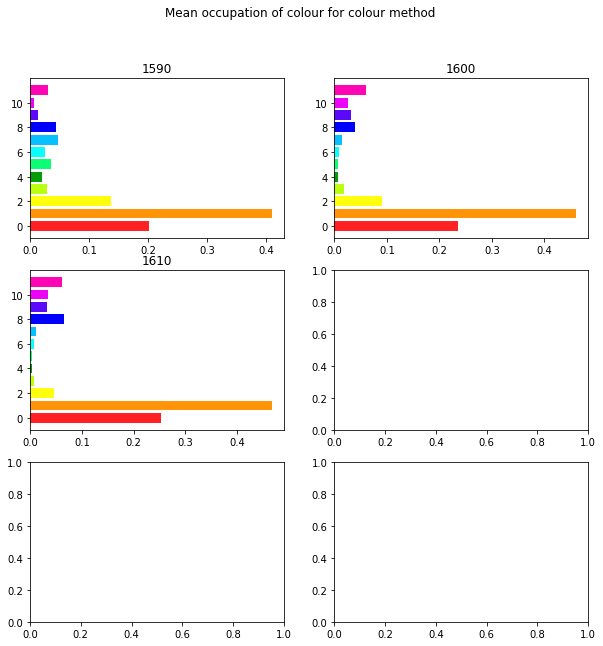

In [53]:
# plotting bars - these are coloured with the RGBs of the colour from colour method
d_plot = d_cm.copy()      # choose the colour method here
d_colours = colours_cm.copy()    # and the relative colours dict

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle('Mean occupation of colour for colour method')

decade = '1590'
x = [k for k in d_plot[decade][next(iter(d_plot[decade]))].keys()]
y =  [np.mean([d_plot[decade][title][k] for title in d_plot[decade]]) for k in x]
colours = [ tuple([item/255 for item in d_colours[i]]) for i in x]   # this must be a list of tuples, as per pyplot
axs[0,0].barh( x, y, color=colours)
axs[0,0].set_title(decade)

decade = '1600'
x = [k for k in d_plot[decade][next(iter(d_plot[decade]))].keys()]
y =  [np.mean([d_plot[decade][title][k] for title in d_plot[decade]]) for k in x]
colours = [ tuple([item/255 for item in d_colours[i]]) for i in x]   # this must be a list of tuples, as per pyplot
axs[0,1].barh( x, y , color=colours)
axs[0,1].set_title(decade)

decade = '1610'
x = [k for k in d_plot[decade][next(iter(d_plot[decade]))].keys()]
y =  [np.mean([d_plot[decade][title][k] for title in d_plot[decade]]) for k in x]
colours = [ tuple([item/255 for item in d_colours[i]]) for i in x] # this must be a list of tuples, as per pyplot
axs[1,0].barh( x, y , color=colours)
axs[1,0].set_title(decade)


plt.show();

#x, y, colours

In [54]:
# tot of titles processed for colour
len(d_af['1590'].keys()) + \
len(d_af['1600'].keys()) + \
len(d_af['1610'].keys())

92

In [85]:
len(d_cm['1590'])

28

In [84]:
d_cm['1590']

{'c. 1598:Judith Beheading Holofernes.jpeg': {0: 0.29,
  1: 0.17,
  2: 0.02,
  3: 0.0,
  4: 0.01,
  5: 0.01,
  6: 0.04,
  7: 0.16,
  8: 0.1,
  9: 0.06,
  10: 0.04,
  11: 0.11},
 'c. 1596:Basket of Fruit.jpeg': {0: 0.05,
  1: 0.54,
  2: 0.38,
  3: 0.02,
  4: 0.01,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  11: 0.0},
 'c. 1597:Portrait of a Courtesan.jpeg': {0: 0.25,
  1: 0.62,
  2: 0.02,
  3: 0.0,
  4: 0.0,
  5: 0.01,
  6: 0.0,
  7: 0.04,
  8: 0.02,
  9: 0.01,
  10: 0.0,
  11: 0.03},
 'c. 1597:Medusa.jpeg': {0: 0.11,
  1: 0.32,
  2: 0.3,
  3: 0.01,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.04,
  8: 0.16,
  9: 0.02,
  10: 0.01,
  11: 0.02},
 'c. 1597:Jupiter, Neptune and Pluto.jpeg': {0: 0.01,
  1: 0.2,
  2: 0.31,
  3: 0.1,
  4: 0.04,
  5: 0.06,
  6: 0.09,
  7: 0.14,
  8: 0.02,
  9: 0.0,
  10: 0.0,
  11: 0.0},
 'c. 1598:John the Baptist.jpeg': {0: 0.25,
  1: 0.32,
  2: 0.23,
  3: 0.09,
  4: 0.07,
  5: 0.02,
  6: 0.01,
  7: 0.01,
  8: 0.01,
  9: 0.0,
  10: 0.0,
  11: 0.01},

## Other refs

* A nice [page](https://realpython.com/python-opencv-color-spaces/) on image segmentation with Python 
* [How to choose a palette for painting](https://www.artsy.net/article/artsy-editorial-4-colors-excel-painting)
* [The colour palettes of 10 famous paintings](https://www.haydnsymons.com/blog/the-colour-palettes-used-by-10-famous-paintings/)